In [39]:
import os
import urllib.request
import pickle

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

matplotlib.pyplot.style.use = 'default'

## Driving data from [wroscoes lane follower](https://wroscoe.github.io/keras-lane-following-autopilot.html)

The dataset is composed of ~7900 images and steering angles collected as I manually drove the car. About 2/3 of the images are with the car between the lines. The other third is of the car starting off course and correcting by driving back to between the lines.

X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)
87 -87 [  1   1   1 ..., -50 -53 -46]
[ 91 210 252]


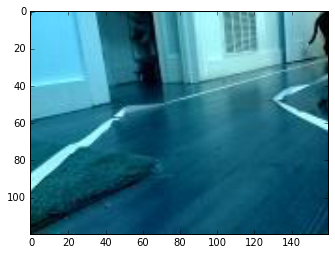

In [2]:
# driving data that has been downloaded from wroscoes
file_path = '../data/indoor_lanes.pkl'
with open(file_path,'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[0])
print(max(Y), min(Y), Y)
print(X[0,0,0,:])

### Data
The data consists of 7892 pictures taken.

** X **

Each picture is of pixel width 120 x 160. Each pixel is composed of 3 colors red blue green. Therefore X has X.shape = (7892,120,160,3)

** Y **

The labels / outputs consist of a integer value between - 90 : 90 for the steering angle of the vehicle. Therefore Y has Y.shape = (7892,). Just a one dimensional vector with interger values.

In [3]:
print("First pixel consist of the colors",X[0,0,0])
print("Steering angle", Y[0])

First pixel consist of the colors [ 91 210 252]
Steering angle 1


## Pre-processing of data

First we seed the data because whenever using a stochastic model we need to use the same seed to get the same results. 
This is so that you can run the same code again and again and get the same result. This is useful if you need to demonstrate a result, compare algorithms using the same source of randomness or to debug a part of your code.

Shuffle the data into 3 parts
* training data
* validation data - avoid overfitting the model
* test data

In [4]:
import numpy as np
seed = 13
np.random.seed(seed)

# Downsampling for faster training of the model
Downsample to almost 2fps to make the pictures less correalated.

Here we download and shuffle the data and split the data into 3 parts. Training, Test, Validation

In [5]:
# downsampling
X = X[0::8]
Y = Y[0::8]

In [6]:
#shuffle  both X and Y the same way
def unison_shuffled_copies(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_copies(X,Y)

len(shuffled_X)

987

In [7]:
test_cutoff = int(len(X) * .8) # 80% of data used for training
val_cutoff = test_cutoff + int(len(X) * .1) # 10% of data used for validation and test data 

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

print("training",len(train_X)/len(X),"validation",len(val_X)/len(X),"test",len(test_X)/len(X))

training 0.7993920972644377 validation 0.09929078014184398 test 0.10131712259371833


# Augment Training Data
To double our training data and prevent steering bias, we flip each image and steering angle and add it to the dataset.
There are additional ways to augment driving data using translations and fake shadows but I didn't use those for this autopilot.

In [8]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

1578

# Building the driving model
Model is based off of Octavio's Carputer. This driving model will be an end-to-end neural network that accepts image arrays as input and ouputs a steering angle between -90 (left) & 90 (right). 
To do this we'll use : 
* **3 layer convolution network with one fully connected layer**

The model does **NOT**  :
* does not produce a throttle value output
* does not use past steering values as input
* uses one less convolution layer.


In [9]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [10]:
img_in = Input(shape=(120,160,3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8,3,3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(16,3,3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2,))(x)

x = Convolution2D(32,3,3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 120, 160, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 118, 158, 8)   224         img_in[0][0]                     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 118, 158, 8)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 59, 79, 8)     0           activation_1[0][0]               
___________________________________________________________________________________________

### Training of the model

The biggest problem you will probably ran into was over fitting the model so that it would not work in evenlly slightly different scenarios. 
* Here are 2 Keras **callbacks** that will save you time.

For those unaware callbacks are 

" description of callbacks "

**Warning** - Training could take up to 3hrs using a CPU

MacbookPro 2016

In [11]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

# Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# stop training if the validation loss doesn't import for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

If you just want to see the first iterations of the model, you could specify that to the model.

Here we will train the model for 4 epochs.

In [12]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=4, validation_data=(val_X, val_Y), callbacks=callbacks_list)

Train on 1578 samples, validate on 98 samples
Epoch 1/4
1578/1578 [==============================] - 19s - loss: 20245.1122 - val_loss: 2090.7325
Epoch 2/4
1578/1578 [==============================] - 18s - loss: 1511.1025 - val_loss: 1572.6564
Epoch 3/4
1578/1578 [==============================] - 19s - loss: 1262.0320 - val_loss: 1413.9136
Epoch 4/4
1578/1578 [==============================] - 19s - loss: 1144.5327 - val_loss: 1207.0655


## Evaluation of the performance

We can check if our models predictions are reasonable by plotting the predictions vs the actual values. The first graph shows that there is a learned relationship in our test data (not seen by model during training).

Here we train out model and plot our predicted output from the training labels

In [16]:
import pandas as pd

# model
# plot predict vs actual

model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],)) 

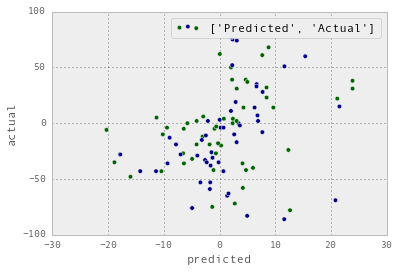

In [40]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual',c=['DarkGreen','DarkBlue'],label=['Predicted','Actual'])
#ax.set_ylabel("steering angle")

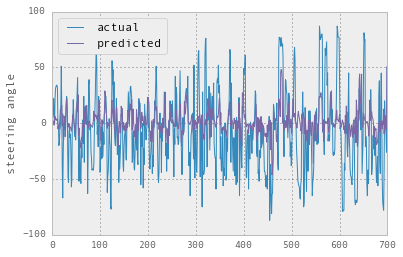

In [41]:
P = model.predict(X[:700])
#predict outputs nested arrays so we need to reshape to plot.
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle")